In [2]:
from tensorflow import keras
from sklearn.model_selection import train_test_split

### Preprocessing

In [67]:
(train_input, train_target), (test_input, test_target) = keras.datasets.fashion_mnist.load_data()
train_scaled = train_input/255.0
train_scaled, val_scaled, train_target, val_target = train_test_split(train_scaled, train_target)

In [73]:
print(len(test_input))

10000


### Define model

In [8]:
def model_fn(a_layer=None):
    model = keras.Sequential()
    model.add(keras.layers.Flatten(input_shape=(28, 28)))
    model.add(keras.layers.Dense(100, activation='relu'))
    
    if a_layer:
        model.add(a_layer)
    
    model.add(keras.layers.Dense(10, activation='softmax'))
    
    return model

In [25]:
model = model_fn()
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_1 (Flatten)         (None, 784)               0         
                                                                 
 dense_2 (Dense)             (None, 100)               78500     
                                                                 
 dense_3 (Dense)             (None, 10)                1010      
                                                                 
Total params: 79510 (310.59 KB)
Trainable params: 79510 (310.59 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [26]:
model.compile(loss='sparse_categorical_crossentropy', metrics='accuracy')
history = model.fit(train_scaled, train_target, epochs=5, verbose=0)

In [27]:
history

In [28]:
history.history.keys()

dict_keys(['loss', 'accuracy'])

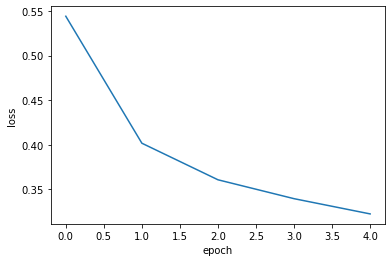

In [29]:
import matplotlib.pyplot as plt

plt.plot(history.history['loss'])
plt.xlabel('epoch')
plt.ylabel('loss')
plt.show()

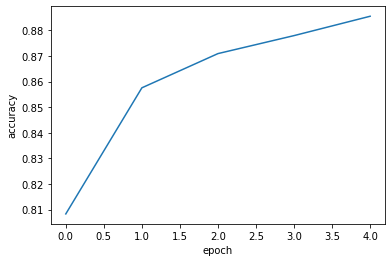

In [30]:
plt.plot(history.history['accuracy'])
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.show()

* epoch이 늘어날수록 loss가 감소하고 accuracy가 증가했다.
* 그렇다면 epoch을 5가 아닌 20으로 한다면?

### epoch= 20

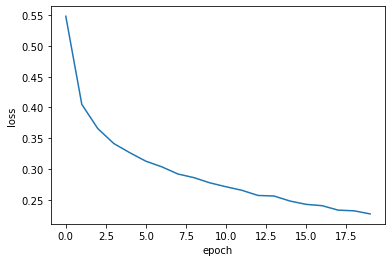

In [31]:
model = model_fn()
model.compile(loss='sparse_categorical_crossentropy', metrics='accuracy')
history = model.fit(train_scaled, train_target, epochs=20, verbose=0)

plt.plot(history.history['loss'])
plt.xlabel('epoch')
plt.ylabel('loss')
plt.show()

### 검증 손실
* train 학습 결과만으로는 성능을 평가하기 어렵다. 과대적합과 과소적합을 파악해야한다.
* 따라서 validation의 결과도 확인해야하는데,
* validation_data 매개변수를 사용한다.

In [33]:
model = model_fn()
model.compile(loss='sparse_categorical_crossentropy', metrics='accuracy')
history = model.fit(train_scaled, train_target, epochs=20, verbose=0, validation_data=(val_scaled, val_target))

In [39]:
print(history.history.keys())

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


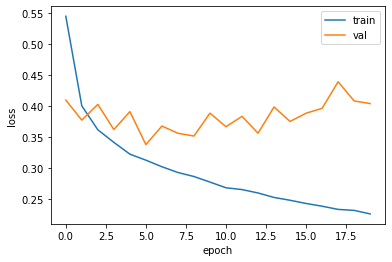

In [41]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['train', 'val'])
plt.show()

* 초기에 검증손실이 감소하다가 다섯 번째 epoch부터 다시 상승하기 시작.
* 훈련손실은 꾸준히 감소하기 때문에 전형적인 과대적합 모델이 만들어졌다.

### 과대적합 방지

* 3장의 '규제방식' 대신 '옵티마이저 하이퍼파라미터 조정'하기

* Adam은 적응적 학습률을 사용하기 때문에 epoch이 진행되면서 학습률의 크기를 조정할 수 있다.
* 먼저 Adam을 사용해 그래프 그려보기

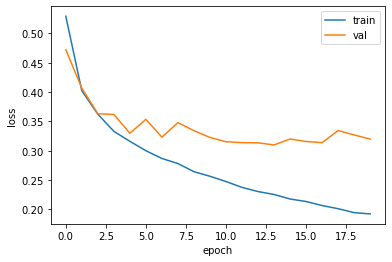

In [45]:
model = model_fn()
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics='accuracy')
history = model.fit(train_scaled, train_target, epochs=20, verbose=0, validation_data=(val_scaled, val_target))

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['train', 'val'])
plt.show()

# dropout

In [50]:
model = model_fn(keras.layers.Dropout(0.3))
model.summary()

Model: "sequential_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_10 (Flatten)        (None, 784)               0         
                                                                 
 dense_20 (Dense)            (None, 100)               78500     
                                                                 
 dropout_1 (Dropout)         (None, 100)               0         
                                                                 
 dense_21 (Dense)            (None, 10)                1010      
                                                                 
Total params: 79510 (310.59 KB)
Trainable params: 79510 (310.59 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


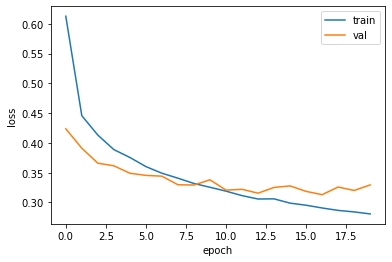

In [51]:
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics='accuracy')
history = model.fit(train_scaled, train_target, epochs=20, verbose=0, validation_data=(val_scaled, val_target))

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['train', 'val'])
plt.show()

# 모델 저장과 복원

In [53]:
model = model_fn(keras.layers.Dropout(0.3))
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics='accuracy')
history = model.fit(train_scaled, train_target, epochs=10, verbose=0, validation_data=(val_scaled, val_target))

In [54]:
# 파라미터 저장
model.save_weights('model-weights.h5')
# 모델구조와 파라미터 함께 저장
model.save('model-whole.h5')

/Users/gimseonjun/anaconda3/lib/python3.9/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [57]:
# 셀 명령어는 ! 사용
!ls -al *.h5

-rw-r--r--  1 gimseonjun  staff  333448  8  7 17:40 model-weights.h5
-rw-r--r--  1 gimseonjun  staff  981360  8  7 17:40 model-whole.h5


### 2가지 실험
1. wight만 사용한 새로운 모델
    * wight만 적재하기 위해서는 save_weights()메서드로 저장했던 모델과 정확히 같은 구조를 가저야한다.
2. whole을 사용한 새로운 모델

### 실험1. 새로운 모델을 만들고 저장했던 모델 파라미터 적재

In [82]:
# 동일한 모델 구조를 만듦
model = model_fn(keras.layers.Dropout(0.3))
model.load_weights('model-weights.h5')

In [74]:
import numpy as np

val_labels = np.argmax(model.predict(val_scaled), axis=-1)
print(np.mean(val_labels==val_target))

469/469 [==============================] - 1s 684us/step
0.8952666666666667


### 실험2. 모델 전체를 파일에서 읽은 다음 검증세트의 정확도 출력

In [81]:
model = keras.models.load_model('model-whole.h5')
model.evaluate(val_scaled, val_target)

469/469 [==============================] - 1s 922us/step - loss: 0.2837 - accuracy: 0.8953


[0.2836901545524597, 0.8952666521072388]

### 결과

같은 모델을 출력했기 때문에 동일한 성능이 나온다

참고)<br>
evaluate를 사용할 수 있는 이유 : 모델 구조와 옵티마이저 상태까지 모두 복원하기 때문.

# 콜백
훈련 과정 중간에 어떤 작업을 수행할 수 있게 하는 객체로 keras.callbacks 패키지 아래에 있는 클래스

In [84]:
model = model_fn(keras.layers.Dropout(0.3))
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics='accuracy')
checkpoint_cb = keras.callbacks.ModelCheckpoint('best-model.h5')
model.fit(train_scaled, train_target, epochs=20, verbose=0,
          validation_data=(val_scaled, val_target), callbacks=[checkpoint_cb])

In [85]:
model = keras.models.load_model('best-model.h5')
model.evaluate(val_scaled, val_target)

469/469 [==============================] - 0s 858us/step - loss: 0.3161 - accuracy: 0.8893


[0.31612521409988403, 0.8892666697502136]

In [86]:
# early stop 사용
# patience / restore_best_weights

model = model_fn(keras.layers.Dropout(0.3))
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics='accuracy')
checkpoint_cb = keras.callbacks.ModelCheckpoint('best-model.h5')
early_stopping_cb = keras.callbacks.EarlyStopping(patience=2, restore_best_weights=True)
history = model.fit(train_scaled, train_target, epochs=20, verbose=0,
          validation_data=(val_scaled, val_target), callbacks=[checkpoint_cb, early_stopping_cb])

In [91]:
early_stopping_cb.stopped_epoch

15

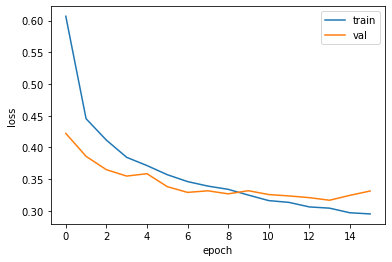

In [92]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['train', 'val'])
plt.show()

### 결과

epoch15에서 멈춘 모델의 그래프를 살펴봤을때, epoch 13에서 가장 낮은 loss가 나타났다.